# Model Implementation of Venomous and Non-venomous Snakes

---

1. Install Dependencies and Setup

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, KFold
from keras.applications import ResNet50, VGG16, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [127]:
data_dir = r'C:\Users\ivanne bayer\Desktop\Computer Science\Comp Sci - Yr. 3 second sem\CS 3201 - Thesis 1\CS 3201 - Implementation\placeholder'

2. Performing EDA

In [128]:
venomous_dir = os.path.join(data_dir, 'venomous')
non_venomous_dir = os.path.join(data_dir, 'non_venomous')

num_venomous = len([f for f in os.listdir(venomous_dir) if os.path.isfile(os.path.join(venomous_dir, f))])
num_non_venomous = len([f for f in os.listdir(non_venomous_dir) if os.path.isfile(os.path.join(non_venomous_dir, f))])

print("Number of Snakes collected")
print("Venomous: " + str(num_venomous))
print("Non-Venomous: " + str(num_non_venomous))

Number of Snakes collected
Venomous: 1653
Non-Venomous: 3178


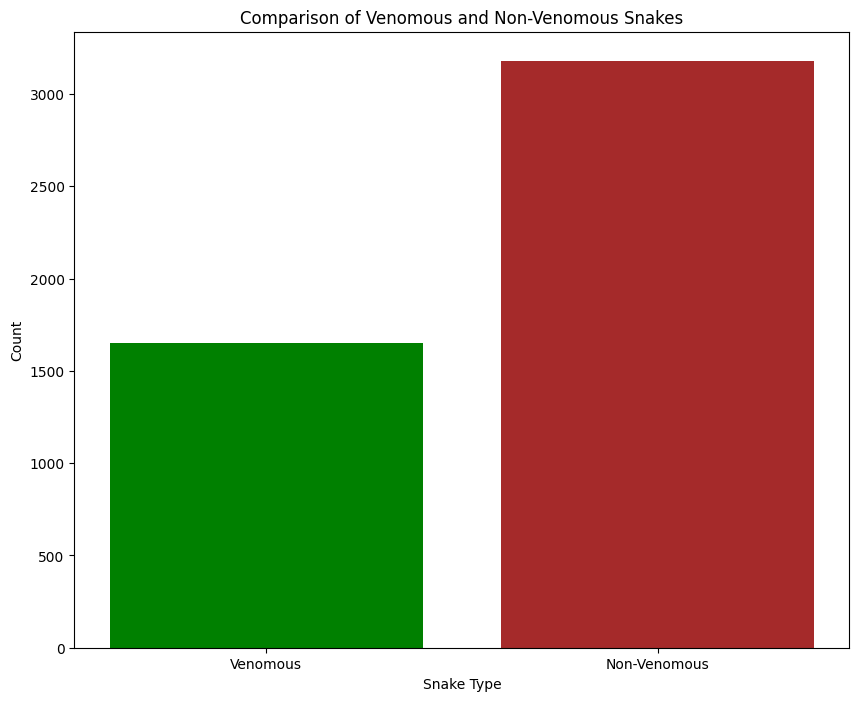

In [129]:
categories = ['Venomous', 'Non-Venomous']
counts = [num_venomous, num_non_venomous]

plt.figure(figsize=(10, 8))
plt.bar(categories, counts, color=['green', 'brown'])
plt.xlabel('Snake Type')
plt.ylabel('Count')
plt.title('Comparison of Venomous and Non-Venomous Snakes')
plt.show()

3. Preprocessing the Images

In [130]:
def load_images_and_labels(data_dir):
    # Label 0 if venomous
    # Label 1 if non-venomous
    X = []
    y = []

    for label, folder in enumerate(['venomous', 'non_venomous']):
        folder_path = os.path.join(data_dir, folder)
        images_in_folder = os.listdir(folder_path)

        for file in images_in_folder:
            file_path = os.path.join(folder_path, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (224, 224))  # Resizing images to 224x224
            image = image.astype('float32') / 255.0  # Normalization to values [0,1]
            X.append(image)
            y.append(label)

        # For venomous snakes, duplicate the images and add augmentation
        if folder == 'venomous':
            venomous_images = X[-len(images_in_folder):]  # Get the original venomous images

            # Data augmentation for the duplicated images
            datagen = ImageDataGenerator(
                horizontal_flip=True,
                zoom_range=0.3
            )
            
            for image in venomous_images:
                augmented_image = datagen.random_transform(image)
                
                X.append(augmented_image)
                y.append(label)

    return np.array(X), np.array(y)

4. Training and Testing Split

In [131]:
X, y = load_images_and_labels(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Should be 6,484 images total
print("Number of images for training:", len(X_train))
print("Number of images for testing:", len(X_test))

Number of images for training: 5187
Number of images for testing: 1297


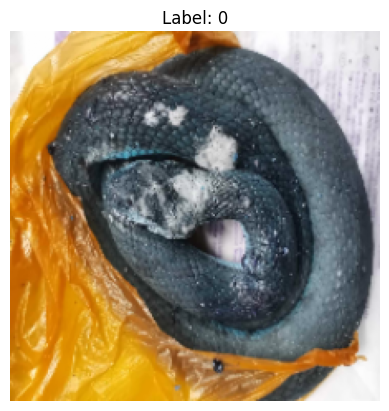

In [132]:
idx = np.random.randint(len(X_train))
image = X_train[idx]
label = y_train[idx]
plt.imshow(image)
plt.title('Label: ' + str(label))
plt.axis('off')
plt.show()

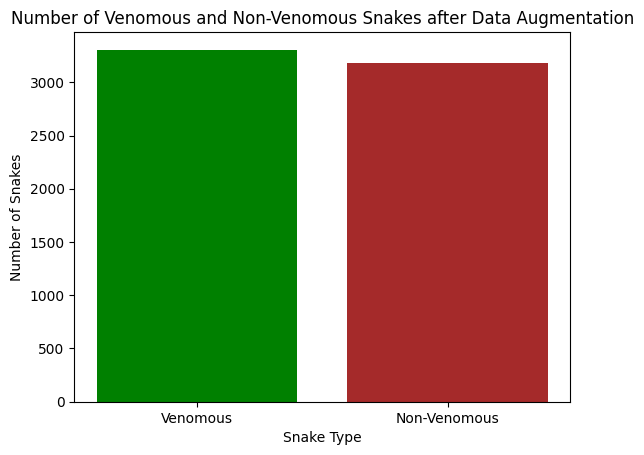

In [133]:
num_venomous = np.sum(y == 0)
num_non_venomous = np.sum(y == 1)

labels = ['Venomous', 'Non-Venomous']
counts = [num_venomous, num_non_venomous]

plt.bar(labels, counts, color=['green', 'brown'])
plt.xlabel('Snake Type')
plt.ylabel('Number of Snakes')
plt.title('Number of Venomous and Non-Venomous Snakes after Data Augmentation')
plt.show()

5. Creating the Models

In [134]:
def create_model(model_name):
    if model_name == 'ResNet50':
        base_model = ResNet50(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'VGG16':
        base_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 256
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'DenseNet201':
        base_model = DenseNet201(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    
    pretrained_model = Sequential([
        base_model,
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return pretrained_model

6. Evaluating the Models

In [135]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Training the model...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    print("Training finished.")
    
    print("Evaluating the model on test data...")
    _, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Evaluation finished.")
    
    return history, accuracy

7. Train the Models and Identify Mean Performance of each Algorithm

In [136]:
models = {'ResNet50': create_model('ResNet50'), 'VGG16': create_model('VGG16'), 'DenseNet201': create_model('DenseNet201')}
accuracies = {}

for name, model in models.items():
    print("Training and evaluating", name)
    history, accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
    accuracies[name] = accuracy
    
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - ' + name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Training and evaluating ResNet50
Training the model...
Epoch 1/10


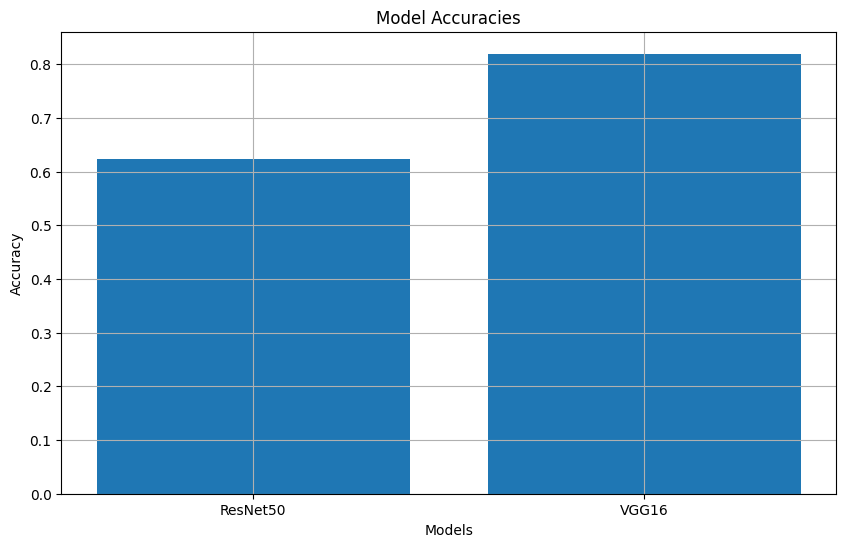

In [ ]:
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.grid(True)
plt.show()